# Lab 09 XOR - tensorboard - eager
* XOR 문제를 Deep Neural Network 활용해 풀어보고 Tensorboard에 출력해 보도록 하겠습니다.

### 기본 Library 선언 및 Tensorflow 버전 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()
tf.set_random_seed(777)  # for reproducibility

print(tf.__version__)

1.12.0


### 강의에 설명할 Data입니다
* x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
* 붉은색과 푸른색으로 0과 1을 표시해 보도록 하겠습니다.

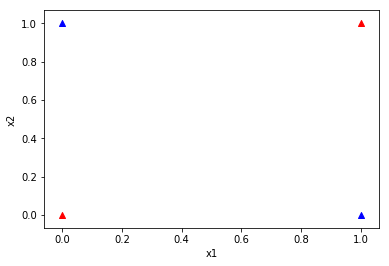

In [2]:
x_data = [[0, 0],
          [0, 1],
          [1, 0],
          [1, 1]]
y_data = [[0],
          [1],
          [1],
          [0]]

plt.scatter(x_data[0][0],x_data[0][1], c='red' , marker='^')
plt.scatter(x_data[3][0],x_data[3][1], c='red' , marker='^')
plt.scatter(x_data[1][0],x_data[1][1], c='blue' , marker='^')
plt.scatter(x_data[2][0],x_data[2][1], c='blue' , marker='^')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

##  Tensorboard
### 위 Data를 기준으로 XOR처리를 위한 모델을 만들도록 하겠습니다
* 위의 Data를 4Layer의 Neural Network를 통해 학습시킨 후 모델을 생성합니다.
* tensorboard --logdir=./logs/ 실행합니다.
* summary 값을 logs폴더에 저장하고 아래 명령어로 실행해서 확인한다 (http://0.0.0.0:6006)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(len(x_data))

def preprocess_data(features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels

### Deep Neural Network를 통해 XOR해결 
* 위의 Data를 4Layer의 Neural Network를 통해 학습시킨 후 모델을 생성합니다. 
* 각각의 값을 histogram으로 tensorboard에 저장한다 (Model)
* 각각의 값을 scalar값으로 tensorboard에 저장한다 (cost, accuracy)

In [4]:
W1 = tf.Variable(tf.random_normal([2, 10]), name='weight1')
b1 = tf.Variable(tf.random_normal([10]), name='bias1')

W2 = tf.Variable(tf.random_normal([10, 10]), name='weight2')
b2 = tf.Variable(tf.random_normal([10]), name='bias2')

W3 = tf.Variable(tf.random_normal([10, 10]), name='weight3')
b3 = tf.Variable(tf.random_normal([10]), name='bias3')

W4 = tf.Variable(tf.random_normal([10, 1]), name='weight4')
b4 = tf.Variable(tf.random_normal([1]), name='bias4')

def neural_net(features):
    layer1 = tf.sigmoid(tf.matmul(features, W1) + b1)
    layer2 = tf.sigmoid(tf.matmul(layer1, W2) + b2)
    layer3 = tf.sigmoid(tf.matmul(layer2, W3) + b3)
    hypothesis = tf.sigmoid(tf.matmul(layer3, W4) + b4)

    with tf.contrib.summary.record_summaries_every_n_global_steps(1):
        tf.contrib.summary.histogram("weights1", W1)
        tf.contrib.summary.histogram("biases1", b1)
        tf.contrib.summary.histogram("layer1", layer1)

        tf.contrib.summary.histogram("weights2", W2)
        tf.contrib.summary.histogram("biases2", b2)
        tf.contrib.summary.histogram("layer2", layer2)

        tf.contrib.summary.histogram("weights3", W3)
        tf.contrib.summary.histogram("biases3", b3)
        tf.contrib.summary.histogram("layer3", layer3)

        tf.contrib.summary.histogram("weights4", W4)
        tf.contrib.summary.histogram("biases4", b4)
        tf.contrib.summary.histogram("hypothesis", hypothesis)
    return hypothesis

def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels * tf.log(hypothesis) + (1 - labels) * tf.log(1 - hypothesis))
    with tf.contrib.summary.record_summaries_every_n_global_steps(1):
        tf.contrib.summary.scalar('loss', cost)
    return cost

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features),labels)
    return tape.gradient(loss_value, [W1, W2, W3, W4, b1, b2, b3, b4])

* summary 값을 logs폴더에 저장하고 아래 명령어로 실행해서 확인한다 (http://0.0.0.0:6006)
* tensorboard --logdir=./logs/

In [5]:
EPOCHS = 3000
log_path = "./logs/xor_eager_logs_r0_01"
writer = tf.contrib.summary.create_file_writer(log_path)
global_step=tf.train.get_or_create_global_step()  # global step variable
writer.set_as_default()

for step in range(EPOCHS):
    global_step.assign_add(1)
    for features, labels  in tfe.Iterator(dataset):
        features, labels = preprocess_data(features, labels)
        grads = grad(neural_net(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W1, W2, W3, W4, b1, b2, b3, b4]))
        if step % 50 == 0:
            loss_value = loss_fn(neural_net(features),labels)
            print("Iter: {}, Loss: {:.4f}".format(step, loss_value))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(neural_net(x_data),y_data)
print("Testset Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 0.9517
Iter: 50, Loss: 0.6936
Iter: 100, Loss: 0.6923
Iter: 150, Loss: 0.6912
Iter: 200, Loss: 0.6901
Iter: 250, Loss: 0.6890
Iter: 300, Loss: 0.6879
Iter: 350, Loss: 0.6867
Iter: 400, Loss: 0.6855
Iter: 450, Loss: 0.6842
Iter: 500, Loss: 0.6827
Iter: 550, Loss: 0.6811
Iter: 600, Loss: 0.6793
Iter: 650, Loss: 0.6772
Iter: 700, Loss: 0.6749
Iter: 750, Loss: 0.6722
Iter: 800, Loss: 0.6690
Iter: 850, Loss: 0.6654
Iter: 900, Loss: 0.6611
Iter: 950, Loss: 0.6561
Iter: 1000, Loss: 0.6502
Iter: 1050, Loss: 0.6432
Iter: 1100, Loss: 0.6349
Iter: 1150, Loss: 0.6251
Iter: 1200, Loss: 0.6134
Iter: 1250, Loss: 0.5992
Iter: 1300, Loss: 0.5821
Iter: 1350, Loss: 0.5612
Iter: 1400, Loss: 0.5357
Iter: 1450, Loss: 0.5047
Iter: 1500, Loss: 0.4677
Iter: 1550, Loss: 0.4248
Iter: 1600, Loss: 0.3774
Iter: 1650, Loss: 0.3281
Iter: 1700, Loss: 0.2798
Iter: 1750, Loss: 0.2356
Iter: 1800, Loss: 0.1971
Iter: 1850, Loss: 0.1649
Iter: 1900, Loss: 0.1385
Iter: 1950, Loss: 0.1173
Iter: 2000, Loss: 0.100